# Determining the age of customers

**Project Description** <br>
The chain supermarket "Bread-Salt" is implementing a computer vision system to process customer photographs. Photo capturing in the checkout area will help determine the age of customers in order to:
- Analyze purchases and suggest products that may interest customers of this age group.
- Monitor the cashiers' integrity when selling alcohol.

The goal is to build a model that can estimate the approximate age of a person based on their photograph, using a dataset of people's photos with their corresponding ages. The evaluation metric for the model is Mean Absolute Error (MAE), and its value should be less than 7.

In this project, we will:
- Conduct an exploratory analysis of the photo dataset.
- Prepare the data for training.
- Train a neural network and evaluate its performance using the MAE metric.

## EDA

In [ ]:
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

# sample size
sample_size = len(labels)
print("Sample size:", sample_size)

Found 7591 validated image filenames.
Размер выборки: 7591


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


The dataframe isn't that large: 7591 photos.

In [ ]:
labels.sample(5)

,file_name,real_age
5514,005514.jpg,30
6458,006462.jpg,33
2626,002626.jpg,32
6479,006483.jpg,32
2921,002921.jpg,16


Everything looks fine, no missing values.

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


The minimum age according to the labeling is 1 year, the maximum is 100 years, and the average age is 31.

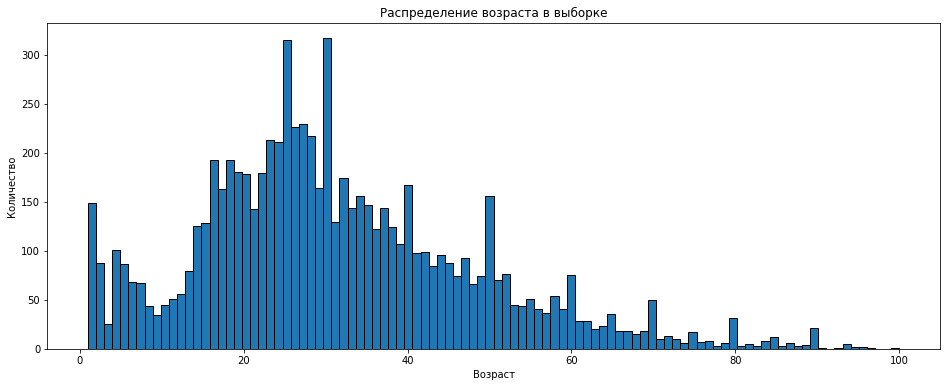

In [ ]:
# age distribution plot
plt.figure(figsize=(16, 6))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number')
plt.title('Age distribution in the sample')
plt.show()

The dataframe is dominated by photos of adults aged 25-40. There is also a large number of children under 5 years old (probably the age of children was not determined very accurately), and there are few people over 60 in the dataset. Judging by the peaks at ages 25, 30, 40, 50, etc., the age for many photos was determined very approximately.

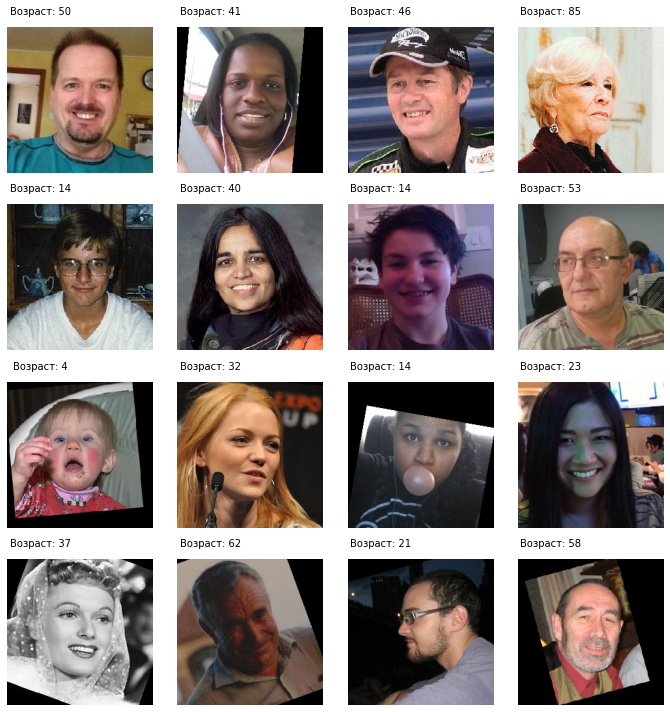

In [ ]:
# displaying 16 random images
features, target = next(gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.axis('off')
    plt.tight_layout()
    plt.text(50, -20, f"Возраст: {target[i]}", fontsize=10, ha="center")

The presented photos are mostly in color, and there are quite a few photos with poor lighting. Some images are vertically misaligned, and only about half of the faces in the dataset are captured in a frontal view – all of these factors can reduce the accuracy of predictions. The labeling on the random sample generally looks plausible.

Let's summarize the shortcomings of the dataset:
- Small dataset size
- Average photo quality
- Approximate accuracy of labeling

## Model training

```python
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                    rescale=1./255.,
                                    horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            shuffle=False,
            seed=12345)
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25,
                                            rescale=1/255.)    
    val_datagen_flow = validation_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            shuffle=False,
            seed=12345)
    
    return val_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=30,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

2023-07-17 04:59:21.893313: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-07-17 04:59:21.895105: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-07-17 04:59:22.774299: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-17 04:59:22.783860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-17 04:59:22.783935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-17 04:59:22.783967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-17 04:59:22.785866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-17 04:59:22.786249: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-17 04:59:22.788228: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-17 04:59:22.789389: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-17 04:59:22.789447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-17 04:59:22.792968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-07-17 04:59:22.965784: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-07-17 04:59:22.971947: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-07-17 04:59:22.972505: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c30fd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-17 04:59:22.972537: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-07-17 04:59:23.127848: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4291130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-17 04:59:23.127891: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-07-17 04:59:23.129959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-17 04:59:23.130030: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-17 04:59:23.130049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-17 04:59:23.130085: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-17 04:59:23.130102: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-17 04:59:23.130118: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-17 04:59:23.130134: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-17 04:59:23.130145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-17 04:59:23.133847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-07-17 04:59:23.133917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-17 04:59:23.478849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-07-17 04:59:23.478903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0
2023-07-17 04:59:23.478913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N
2023-07-17 04:59:23.482711: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-17 04:59:23.482771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/50
2023-07-17 04:59:34.670520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-17 04:59:34.953297: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 50s - loss: 238.1668 - mae: 11.1188 - val_loss: 697.6581 - val_mae: 21.5167
Epoch 2/50
178/178 - 40s - loss: 75.2622 - mae: 6.5787 - val_loss: 342.6374 - val_mae: 13.7515
Epoch 3/50
178/178 - 40s - loss: 50.1833 - mae: 5.4271 - val_loss: 226.9631 - val_mae: 11.4683
Epoch 4/50
178/178 - 40s - loss: 36.1207 - mae: 4.5901 - val_loss: 128.6441 - val_mae: 8.9682
Epoch 5/50
178/178 - 40s - loss: 28.3615 - mae: 4.0838 - val_loss: 86.4992 - val_mae: 7.1173
Epoch 6/50
178/178 - 40s - loss: 22.9628 - mae: 3.6312 - val_loss: 69.9729 - val_mae: 6.2903
Epoch 7/50
178/178 - 40s - loss: 15.9075 - mae: 3.0050 - val_loss: 68.8856 - val_mae: 6.1228
Epoch 8/50
178/178 - 43s - loss: 12.0258 - mae: 2.5753 - val_loss: 73.0865 - val_mae: 6.4035
Epoch 9/50
178/178 - 60s - loss: 10.5071 - mae: 2.4198 - val_loss: 71.6448 - val_mae: 6.3180
Epoch 10/50
178/178 - 63s - loss: 10.1113 - mae: 2.3793 - val_loss: 72.5973 - val_mae: 6.2776
Epoch 11/50
178/178 - 46s - loss: 7.8061 - mae: 2.0914 - val_loss: 68.7152 - val_mae: 6.1209
Epoch 12/50
178/178 - 62s - loss: 7.4423 - mae: 2.0523 - val_loss: 64.2371 - val_mae: 5.9805
Epoch 13/50
178/178 - 63s - loss: 8.0955 - mae: 2.1398 - val_loss: 65.7281 - val_mae: 6.1153
Epoch 14/50
178/178 - 46s - loss: 7.3363 - mae: 2.0358 - val_loss: 68.5361 - val_mae: 6.3090
Epoch 15/50
178/178 - 63s - loss: 6.1956 - mae: 1.8787 - val_loss: 60.7712 - val_mae: 5.7426
Epoch 16/50
178/178 - 59s - loss: 6.8070 - mae: 1.9480 - val_loss: 65.4449 - val_mae: 6.0760
Epoch 17/50
178/178 - 49s - loss: 6.9159 - mae: 1.9781 - val_loss: 66.2784 - val_mae: 6.0479
Epoch 18/50
178/178 - 63s - loss: 7.2117 - mae: 1.9951 - val_loss: 65.5501 - val_mae: 5.9740
Epoch 19/50
178/178 - 52s - loss: 7.0855 - mae: 2.0029 - val_loss: 79.8411 - val_mae: 6.7823
Epoch 20/50
178/178 - 43s - loss: 7.5946 - mae: 2.0849 - val_loss: 69.2268 - val_mae: 6.2768
Epoch 21/50
178/178 - 51s - loss: 7.3701 - mae: 2.0486 - val_loss: 63.7597 - val_mae: 6.0193
Epoch 22/50
178/178 - 50s - loss: 7.2720 - mae: 2.0286 - val_loss: 79.3733 - val_mae: 6.6944
Epoch 23/50
178/178 - 64s - loss: 7.3703 - mae: 2.0301 - val_loss: 63.0134 - val_mae: 5.8093
Epoch 24/50
178/178 - 74s - loss: 7.2478 - mae: 2.0154 - val_loss: 62.5738 - val_mae: 5.7832
Epoch 25/50
178/178 - 64s - loss: 6.6873 - mae: 1.9383 - val_loss: 65.4677 - val_mae: 6.0323
Epoch 26/50
178/178 - 73s - loss: 7.0315 - mae: 1.9386 - val_loss: 61.3891 - val_mae: 5.6425
Epoch 27/50
178/178 - 72s - loss: 6.5445 - mae: 1.9295 - val_loss: 60.8668 - val_mae: 5.8558
Epoch 28/50
178/178 - 57s - loss: 6.7612 - mae: 1.9574 - val_loss: 62.8920 - val_mae: 5.9110
Epoch 29/50
178/178 - 72s - loss: 6.2001 - mae: 1.8834 - val_loss: 61.2444 - val_mae: 5.8530
Epoch 30/50
178/178 - 69s - loss: 5.5324 - mae: 1.7781 - val_loss: 65.0028 - val_mae: 6.0592
Epoch 31/50
178/178 - 65s - loss: 6.0790 - mae: 1.8252 - val_loss: 58.8388 - val_mae: 5.5922
Epoch 32/50
178/178 - 73s - loss: 10.6813 - mae: 2.4081 - val_loss: 63.1817 - val_mae: 6.0066
Epoch 33/50
178/178 - 66s - loss: 8.5464 - mae: 2.2102 - val_loss: 67.2225 - val_mae: 6.0736
Epoch 34/50
178/178 - 73s - loss: 7.3177 - mae: 2.0235 - val_loss: 63.4094 - val_mae: 6.0181
Epoch 35/50
178/178 - 73s - loss: 5.9360 - mae: 1.8277 - val_loss: 59.3751 - val_mae: 5.7688
Epoch 36/50
178/178 - 55s - loss: 4.8054 - mae: 1.6430 - val_loss: 57.8088 - val_mae: 5.5021
Epoch 37/50
178/178 - 70s - loss: 4.0343 - mae: 1.4997 - val_loss: 61.6627 - val_mae: 5.9419
Epoch 38/50
178/178 - 49s - loss: 3.9881 - mae: 1.4760 - val_loss: 60.2355 - val_mae: 5.6469
Epoch 39/50
178/178 - 46s - loss: 3.6876 - mae: 1.4308 - val_loss: 57.1545 - val_mae: 5.5234
Epoch 40/50
178/178 - 37s - loss: 3.5713 - mae: 1.4073 - val_loss: 58.8783 - val_mae: 5.6718
Epoch 41/50
178/178 - 38s - loss: 3.2959 - mae: 1.3549 - val_loss: 59.7628 - val_mae: 5.6261
Epoch 42/50
178/178 - 37s - loss: 3.2580 - mae: 1.3394 - val_loss: 62.5074 - val_mae: 5.9241
Epoch 43/50
178/178 - 38s - loss: 3.6796 - mae: 1.4162 - val_loss: 55.9214 - val_mae: 5.5143
Epoch 44/50
178/178 - 38s - loss: 3.9519 - mae: 1.4747 - val_loss: 59.6253 - val_mae: 5.7444
Epoch 45/50
178/178 - 38s - loss: 4.1332 - mae: 1.5217 - val_loss: 66.7793 - val_mae: 6.0153
Epoch 46/50
178/178 - 38s - loss: 4.2936 - mae: 1.5708 - val_loss: 59.6053 - val_mae: 5.6544
Epoch 47/50
178/178 - 38s - loss: 4.5920 - mae: 1.6109 - val_loss: 59.0650 - val_mae: 5.6671
Epoch 48/50
178/178 - 38s - loss: 4.6242 - mae: 1.5966 - val_loss: 68.0026 - val_mae: 6.0746
Epoch 49/50
178/178 - 38s - loss: 4.7220 - mae: 1.6145 - val_loss: 60.8749 - val_mae: 5.6215
Epoch 50/50
178/178 - 38s - loss: 4.3723 - mae: 1.5722 - val_loss: 60.2399 - val_mae: 5.7312
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 60.2399 - mae: 5.7312
Test MAE: 5.7312

```

Test MAE: 5.7312

## Model analysis

To solve the task, the ResNet50 architecture with a backbone, Adam optimizer, and ReLU activation function was used. The achieved MAE value of 5.7312 is below the specified maximum (7), so the condition is met.

Regarding the model's application, due to the prevalence of people aged 25-40 in the original data, the model will perform best in recognizing visitors of this age group. To improve the accuracy of recognizing minors and avoid selling alcohol to them, the model should be fine-tuned on a dataset of faces younger than 18-21 with more accurate labeling. With the recommendation of potentially interesting products based on age, the obtained model will perform well. However, it is advisable to fine-tune the model on photos of people older than 45 to improve their recommendations.